In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
import pandas as pd
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from google.colab import files ,drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ----------------------------
# 1) Load & split the dataset

# Load the dataset
from datasets import load_dataset
df = pd.read_parquet("hf://datasets/TimKoornstra/synthetic-financial-tweets-sentiment/data/train-00000-of-00001.parquet")

# Sample 5% of the data
df_sampled = df.sample(frac=1, random_state=42)  # frac=0.05 to get 5%

# Optionally, you can reset the index of the sampled DataFrame
df_sampled = df_sampled.reset_index(drop=True)

# Check the shape of the sampled data
print(f"Original data size: {len(df)}")
print(f"Sampled data size: {len(df_sampled)}")

# Split the DataFrame into training and validation (80/20 split)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

# (Optional) Save the splits as CSV if desired
# train_df.to_csv("train.csv", index=False)
# val_df.to_csv("val.csv", index=False)

# Convert the Pandas DataFrames to Hugging Face Dataset format
hf_train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
hf_val_dataset   = Dataset.from_pandas(val_df.reset_index(drop=True))

# -------------------------------
# 2) Define FinBERT & Tokenizer
# -------------------------------
model_name = "prajjwal1/bert-tiny"    # Pretrained FinBERT
num_labels = 3                     # This dataset has 3 sentiment classes
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# ----------------------
# 3) Tokenize Function
# ----------------------
def tokenize_function(example):
    return tokenizer(
        example["tweet"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# Map the tokenization over the entire dataset
hf_train_dataset = hf_train_dataset.map(tokenize_function, batched=True)
hf_val_dataset   = hf_val_dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Original data size: 1428771
Sampled data size: 1428771
Training size: 1143016
Validation size: 285755


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1143016 [00:00<?, ? examples/s]

Map:   0%|          | 0/285755 [00:00<?, ? examples/s]

In [5]:
# Rename the label column to 'labels' for the Trainer
# Rename the 'sentiment' column to 'labels' for the Trainer
hf_train_dataset = hf_train_dataset.rename_column("sentiment", "labels")
hf_val_dataset = hf_val_dataset.rename_column("sentiment", "labels")


# Remove unused columns (tweet, id, etc.)
hf_train_dataset = hf_train_dataset.remove_columns(["tweet"])
hf_val_dataset   = hf_val_dataset.remove_columns(["tweet"])

# Set the format to PyTorch tensors
hf_train_dataset.set_format("torch")
hf_val_dataset.set_format("torch")

# ---------------------------
# 4) Define compute_metrics
# ---------------------------
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [8]:
# -----------------------------
# 5) Training Arguments
# -----------------------------
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Tiny Bert Weights",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=8,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True
)

# -----------------------------
# 6) Initialize Trainer
# -----------------------------
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)  # Stop if no improvement after 3 evaluations

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]  # Add the early stopping callback
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
# -----------------------------
# 7) Train and Evaluate
# -----------------------------
trainer.train()
eval_metrics = trainer.evaluate()
print("Validation metrics:", eval_metrics)

# -----------------------------
# 8) (Optional) Save Model
# -----------------------------
trainer.save_model("/content/drive/MyDrive/Tiny Bert Weights")
tokenizer.save_pretrained("/content/drive/MyDrive/Tiny Bert Weights")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.222400,0.203846,0.921748,0.921502,0.921748,0.921598
2,0.209600,0.189051,0.927494,0.927457,0.927494,0.927470
3,0.189900,0.184945,0.929999,0.929694,0.929999,0.929778
4,0.189200,0.176682,0.932442,0.932390,0.932442,0.932415
5,0.164500,0.175222,0.933537,0.933558,0.933537,0.933540
6,0.177700,0.172289,0.934244,0.934221,0.934244,0.934222
7,0.170400,0.171479,0.934990,0.934916,0.934990,0.934948
8,0.166700,0.170765,0.935322,0.935274,0.935322,0.935297


Validation metrics: {'eval_loss': 0.1707652509212494, 'eval_accuracy': 0.9353222165841367, 'eval_precision': 0.9352737684624248, 'eval_recall': 0.9353222165841367, 'eval_f1': 0.9352971421521278, 'eval_runtime': 25.811, 'eval_samples_per_second': 11071.066, 'eval_steps_per_second': 172.988, 'epoch': 8.0}


('/content/drive/MyDrive/Tiny Bert Weights/tokenizer_config.json',
 '/content/drive/MyDrive/Tiny Bert Weights/special_tokens_map.json',
 '/content/drive/MyDrive/Tiny Bert Weights/vocab.txt',
 '/content/drive/MyDrive/Tiny Bert Weights/added_tokens.json',
 '/content/drive/MyDrive/Tiny Bert Weights/tokenizer.json')

In [10]:
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Tiny Bert Weights")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Tiny Bert Weights")

In [11]:
# -----------------------------
# 5) Training Arguments
# -----------------------------
from transformers import EarlyStoppingCallback, get_scheduler, AdamW

training_args = TrainingArguments(
    output_dir="/content/TinyBert-fine-tuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=8,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True
)

# -----------------------------
# 6) Initialize Trainer
# -----------------------------
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

optimizer = AdamW(model.parameters(), lr=2e-5)

 # Stop if no improvement after 3 evaluations
num_training_steps = len(hf_train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
num_warmup_steps = int(0.1 * num_training_steps)  # 10% of steps for warmup
scheduler = get_scheduler(
    name="linear",  # Choose the type of scheduler (e.g., linear, cosine, etc.)
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
    optimizers=(optimizer, scheduler) # Add the early stopping callback
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
trainer.train()
eval_metrics = trainer.evaluate()
print("Validation metrics:", eval_metrics)

# -----------------------------
# 8) (Optional) Save Model
# -----------------------------
trainer.save_model("/content/drive/MyDrive/Tiny Bert Weights")
tokenizer.save_pretrained("/content/drive/MyDrive/Tiny Bert Weights")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.167400,0.169520,0.935364,0.935271,0.935364,0.935302
2,0.172800,0.165187,0.936960,0.937033,0.936960,0.936986
3,0.160700,0.163378,0.937950,0.937866,0.937950,0.937901
4,0.163000,0.161132,0.938706,0.938721,0.938706,0.938693
5,0.156000,0.161101,0.939312,0.939306,0.939312,0.939300
6,0.147800,0.159741,0.939662,0.939695,0.939662,0.939665
7,0.148700,0.160451,0.939875,0.939839,0.939875,0.939831
8,0.143300,0.159548,0.940075,0.940067,0.940075,0.940070


Validation metrics: {'eval_loss': 0.15954828262329102, 'eval_accuracy': 0.9400745393781386, 'eval_precision': 0.9400669548813697, 'eval_recall': 0.9400745393781386, 'eval_f1': 0.9400702787850187, 'eval_runtime': 21.0743, 'eval_samples_per_second': 13559.397, 'eval_steps_per_second': 105.958, 'epoch': 8.0}


('/content/drive/MyDrive/Tiny Bert Weights/tokenizer_config.json',
 '/content/drive/MyDrive/Tiny Bert Weights/special_tokens_map.json',
 '/content/drive/MyDrive/Tiny Bert Weights/vocab.txt',
 '/content/drive/MyDrive/Tiny Bert Weights/added_tokens.json',
 '/content/drive/MyDrive/Tiny Bert Weights/tokenizer.json')

In [13]:
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Tiny Bert Weights")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Tiny Bert Weights")

In [14]:
# -----------------------------
# 5) Training Arguments
# -----------------------------
from transformers import EarlyStoppingCallback, get_scheduler, AdamW

training_args = TrainingArguments(
    output_dir="/content/TinyBert-fine-tuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=8,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=512,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True
)

# -----------------------------
# 6) Initialize Trainer
# -----------------------------
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)

optimizer = AdamW(model.parameters(), lr=1e-5)

 # Stop if no improvement after 3 evaluations
num_training_steps = len(hf_train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
num_warmup_steps = int(0.1 * num_training_steps)  # 10% of steps for warmup
scheduler = get_scheduler(
    name="linear",  # Choose the type of scheduler (e.g., linear, cosine, etc.)
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
    optimizers=(optimizer, scheduler) # Add the early stopping callback
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
trainer.train()
eval_metrics = trainer.evaluate()
print("Validation metrics:", eval_metrics)

# -----------------------------
# 8) (Optional) Save Model
# -----------------------------
trainer.save_model("/content/drive/MyDrive/Tiny Bert Weights")
tokenizer.save_pretrained("/content/drive/MyDrive/Tiny Bert Weights")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.149700,0.158674,0.940145,0.940182,0.940145,0.940163
2,0.144800,0.158504,0.940372,0.940380,0.940372,0.940361
3,0.144400,0.157589,0.940739,0.940718,0.940739,0.940729
4,0.145100,0.157756,0.940543,0.940593,0.940543,0.940541
5,0.145000,0.156891,0.940883,0.940859,0.940883,0.940867
6,0.142800,0.156970,0.940967,0.940961,0.940967,0.940962
7,0.142300,0.156993,0.941054,0.941048,0.941054,0.941045
8,0.142100,0.156839,0.941075,0.941067,0.941075,0.941070


Validation metrics: {'eval_loss': 0.1568385660648346, 'eval_accuracy': 0.9410753967559623, 'eval_precision': 0.9410672472890272, 'eval_recall': 0.9410753967559623, 'eval_f1': 0.9410697424283339, 'eval_runtime': 18.3238, 'eval_samples_per_second': 15594.746, 'eval_steps_per_second': 30.507, 'epoch': 8.0}


('/content/drive/MyDrive/Tiny Bert Weights/tokenizer_config.json',
 '/content/drive/MyDrive/Tiny Bert Weights/special_tokens_map.json',
 '/content/drive/MyDrive/Tiny Bert Weights/vocab.txt',
 '/content/drive/MyDrive/Tiny Bert Weights/added_tokens.json',
 '/content/drive/MyDrive/Tiny Bert Weights/tokenizer.json')

In [16]:
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Tiny Bert Weights")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Tiny Bert Weights")
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-1

In [17]:
df = pd.read_parquet("hf://datasets/TimKoornstra/financial-tweets-sentiment/data/train-00000-of-00001.parquet")
print("Class distribution in full dataset:")
print(df['sentiment'].value_counts())

# Balance the dataset by taking an equal number of samples from each label
min_class_count = df['sentiment'].value_counts().min()
balanced_df = df.groupby('sentiment').apply(lambda x: x.sample(n=min_class_count, random_state=42)).reset_index(drop=True)

# Check class distribution after balancing
print("\nClass distribution after balancing:")
print(balanced_df['sentiment'].value_counts())

Class distribution in full dataset:
sentiment
1    17368
0    12181
2     8542
Name: count, dtype: int64

Class distribution after balancing:
sentiment
0    8542
1    8542
2    8542
Name: count, dtype: int64


<ipython-input-17-0b7fe129751a>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('sentiment').apply(lambda x: x.sample(n=min_class_count, random_state=42)).reset_index(drop=True)


In [22]:
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, text_column, label_column, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.text_column = text_column
        self.label_column = label_column
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx][self.text_column]
        label = self.data.iloc[idx][self.label_column]

        # Tokenize with padding and truncation
        tokens = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

In [23]:
import numpy as np
def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            # Calculate accuracy
            predictions = outputs.logits.argmax(dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy, np.array(all_predictions), np.array(all_labels)

In [24]:
from torch.utils.data import DataLoader, Dataset
text_column = "tweet"
label_column = "sentiment"
# Define the dataset
validation_dataset1 = SentimentDataset(balanced_df, tokenizer, text_column, label_column)

# Create the DataLoader
validation_loader1 = DataLoader(validation_dataset1, batch_size=128, shuffle=False)

Validation Loss: 0.4892
Validation Accuracy: 0.8324


<Figure size 1000x800 with 0 Axes>

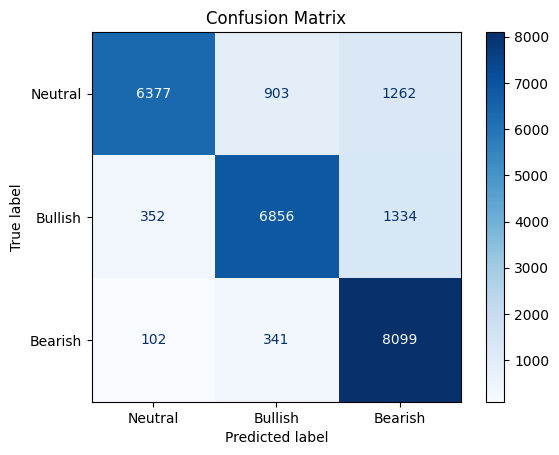


Classification Report:
              precision    recall  f1-score   support

     Neutral     0.9335    0.7465    0.8296      8542
     Bullish     0.8464    0.8026    0.8239      8542
     Bearish     0.7573    0.9481    0.8420      8542

    accuracy                         0.8324     25626
   macro avg     0.8457    0.8324    0.8319     25626
weighted avg     0.8457    0.8324    0.8319     25626



In [25]:
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report ,confusion_matrix, ConfusionMatrixDisplay
# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Validate the model
val_loss, val_accuracy, predictions, labels = validate_model(model, validation_loader1, criterion, "cuda")

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

cm = confusion_matrix(labels, predictions)
classes = ["Neutral", "Bullish", "Bearish"]  # Replace with your actual class names

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

report = classification_report(labels, predictions, target_names=classes, digits=4)
print("\nClassification Report:")
print(report)